# SMBH luminosity function, Better name? 

Juan Urrutia, December 2025

## Imports

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from scipy.misc import derivative
from scipy.interpolate import RegularGridInterpolator,interp1d,LinearNDInterpolator, BSpline, make_interp_spline
from scipy.integrate import quad, fixed_quad, quadrature, simps, romberg, trapezoid, nquad, dblquad, cumulative_trapezoid
from scipy.stats import qmc, gaussian_kde
from IPython.display import display, Math
import pickle
import os
import pandas as pd
from sklearn.neighbors import KernelDensity
import argparse
import time
import sys

## General Cosmology

In [18]:
#Constants and cosmological parameters 
kpc=1;
s=1;
kg=1;
meter = 3.24e-20*kpc;
G = 6.674e-11*meter**3/kg/s**2;
c = 2.998e8*meter/s;
Msun = 1.99e30*kg;
h = 0.674;
𝛔8 = 0.811;
ΩM = 0.315;
Ωb = 0.0493;
zeq = 3402;
T0 = 2.7255;
ns = 0.965;

#Densities

def solve_Omega_R():
    return ΩM * (1 + zeq)**3 / (1 + zeq)**4    
ΩR = solve_Omega_R()
ΩL = 1 - ΩM - ΩR
Ωc = ΩM - Ωb
H0 = 100 * h * meter
def AH(z):
    return np.sqrt(ΩM * (1 + z)**3 + ΩR * (1 + z)**4 + ΩL)
def H(z):
    return H0 * AH(z)
def ΩMz(z):
    return ΩM * (1 + z)**3 / AH(z)**2
def ΩLz(z):
    return ΩL / AH(z)**2
𝜌c = 3 * H0**2 / (8 * np.pi * G)
Ω0 = 0.32
Ωb = 0.05
𝜌0 = Ω0 * 277.5 * h**2
𝜌M0 = 𝜌c * ΩM / Msun * kpc**3
keq = H(zeq)/(1+zeq)*kpc/c;

# Distances
logz_grid = np.arange(-6, 4.01, 0.01)
z_vals = 10 ** logz_grid
dc_points = []
for z in z_vals:
    if z == 0:
        dc_points.append(0)
    else:
        integrand = lambda x: c / H(x) / kpc
        val, _ = quad(integrand, 0, z,epsabs=1e-12,epsrel=1e-12)
        dc_points.append(val)
dc = interp1d(z_vals, dc_points, kind='linear', fill_value="extrapolate")

def DVc(z):
    dz = 1e-1
    dcdz = (dc(z + dz) - dc(z- dz)) / (2*dz)
    return 4 * np.pi * dc(z)**2 * dcdz
    
def zDLf(DL):
    def func(z):
        return (1 + z) * dc(z) - DL
    sol = root_scalar(func, bracket=[0, 2e3], method='brentq')
    return sol.root if sol.converged else np.nan
def DLz(z):
    return (1 + z) * dc(z)
    
def tza(z):
    integrand = lambda x: 1 / ((1 + x) * H(x))
    return quad(integrand, z, np.inf)[0]
tz_points = np.concatenate([np.linspace(-0.999, 0, 200), np.linspace(0.0001, 100, 300)])
tz_vals = [tza(z) for z in tz_points]
tz = interp1d(tz_points, tz_vals, kind='cubic', fill_value="extrapolate")
zt = interp1d(tz_vals, tz_points, kind='cubic', fill_value="extrapolate")

#Growth of perturbations

def Dg(z):
    return 5/2*ΩMz(z)/(ΩMz(z)**(4/7)-ΩLz(z)+(1+ΩMz(z)/2)*(1+ΩLz(z)/70))/(1+z)/0.78694
def 𝛿(z):
    return 3 * (12 * np.pi)**(2/3) / 20 * (1 + 0.123 * np.log10(ΩL * (1 + z)**3 / (ΩL * (1 + z)**3 + 1 -ΩL)))
def 𝛿c(z):
    return 3 / 5 * (3 * np.pi / 2)**(2/3) / Dg(z)

In [19]:
# Matter power spectrum

def T(kk):
    ksilk = 1.6 * (Ωb * h**2)**0.52 * (ΩM * h**2)**0.73 * (1 + (10.4 * ΩM * h**2)**-0.95) / 1e3
    a1 = (46.9 * ΩM * h**2)**0.67 * (1 + (32.1 * ΩM * h**2)**-0.532)
    a2 = (12.0 * ΩM * h**2)**0.424 * (1 + (45.0 * ΩM * h**2)**-0.582)
    b1 = 0.944 * (1 + (458 * ΩM * h**2)**-0.708)**-1
    b2 = (0.395 * ΩM* h**2)**(-0.026)
    alpha_cnum = a1**(-Ωb / ΩM) * a2**(-(Ωb / ΩM)**3)
    beta_cnum = 1 / (1 + b1 * ((Ωc / ΩM)**b2 - 1))
    def q(k): return k / (13.41 * keq)
    def C1(k, alpha_c): return 14.2 / alpha_c + 386 / (1 + 69.9 * q(k)**1.08)
    def To1(k, alpha_c, beta_c): return np.log(np.e + 1.8 * beta_c * q(k)) / (np.log(np.e + 1.8 * beta_c * q(k)) + C1(k, alpha_c) * q(k)**2)
    s2 = 44.5 * np.log(9.83 / (ΩM * h**2)) / np.sqrt(1 + 10 * (Ωb * h**2)**(3/4)) * 1e3
    def f(k): return 1 / (1 + (k * s2 / 5.4)**4)
    def Tc(k): return f(k) * To1(k, 1, beta_cnum) + (1 - f(k)) * To1(k, alpha_cnum, beta_cnum)
    def jo(x): return np.sin(x) / x
    def g2(y): return y * (-6 * np.sqrt(1 + y) + (2 + 3 * y) * np.log((np.sqrt(1 + y) + 1) / (np.sqrt(1 + y) - 1)))
    zeq = 2.50e4 * ΩM * h**2 * (T0 / 2.7)**-4
    b3 = 0.313 * (ΩM * h**2)**-0.419 * (1 + 0.607 * (ΩM * h**2)**0.674)
    b4 = 0.238 * (ΩM * h**2)**0.223
    zd = 1291 * (ΩM * h**2)**0.251 / (1 + 0.659 * (ΩM * h**2)**0.828) * (1 + b3 * (Ωb * h**2)**b4)
    Rd = 31.5 * Ωb * h**2 * (T0 / 2.7)**-4 * (zd / 1e3)**-1
    alpha_b = 2.07 * keq * s2 * (1 + Rd)**(-3/4) * g2((1 + zeq) / (1 + zd))
    beta_b = 0.5 + Ωb / ΩM + (3 - 2 * Ωb / ΩM) * np.sqrt(1 + (17.2 * ΩM * h**2)**2)
    beta_node = 8.41 * (ΩM * h**2)**0.435
    def s3(k): return s2 / (1 + (beta_node / (k * s2))**3)**(1/3)
    def Tb(k): return (To1(k, 1, 1) / (1 + (k * s2 / 5.2)**2) + alpha_b / (1 + (beta_b / (k * s2))**3) * np.exp(-(k / ksilk)**1.4)) * jo(k * s3(k))
    return Ωb / ΩM * Tb(kk) + Ωc / ΩM * Tc(kk)
    
def CapitalDelta(k):
    delta_h = 0.00005
    return np.sqrt(delta_h**2 * (c * k / H0)**(3 + ns) * np.abs(T(k))**2)

def P(k):
    return CapitalDelta(k)**2 * (2 * np.pi**2) / k**3

def j1(x):
    return (x * np.cos(x) - np.sin(x)) / x**2

R8 = 8 / h * 1e3

### DM dependent terms

In [20]:
# Matter density variance in CDM 
def WFT(x):
   return 3*(np.sin(x)-x*np.cos(x))/(x**3)
def 𝛔f(M):
    def r(Mc):
        return (3*Mc/(4*np.pi*𝜌M0))**(1/3)
    val, _ = quad(lambda logk:10**(3*logk) * WFT(r(M)*10**logk)**2 * P(10**logk), -20, 20, epsrel=1e-2)
    return 1/(np.sqrt(2)*np.pi) * np.sqrt(np.log(10)*val)
    
log10m_vals = np.arange(-16, 32.1, 0.1)
m_vals = 10**log10m_vals
𝛔2_vals = np.array([𝛔f(m) for m in m_vals])
𝛔2_interp = make_interp_spline(m_vals, 𝛔2_vals, k=1)
def 𝛔CDM2(M):
    ref_mass = 2.7803939422903778e14
    return 𝛔8 / 𝛔2_interp(ref_mass) * 𝛔2_interp(M)
𝛔CDM_vals = np.array([𝛔CDM2(m) for m in m_vals])
𝛔CDM = make_interp_spline(m_vals,𝛔CDM_vals, k=1)
d𝛔dM= 𝛔CDM.derivative()

## GW physics

In [68]:
# Unit conversions and placeholders
year = 3.15576*1e7
fyr = 1 / year

def McEta(m1, m2):
    return np.array([
        (m1 * m2) ** (3.0 / 5.0) / (m1 + m2) ** (1.0 / 5.0),
        (m1 * m2) / (m1 + m2) ** 2.0])

def m1m2(Mc, eta):
    M = Mc / (eta ** (3.0 / 5.0))
    delta = np.sqrt(1.0 - 4.0 * eta)
    m1 = 0.5 * M * (1.0 + delta)
    m2 = 0.5 * M * (1.0 - delta)
    return np.array([m1, m2])

def tins(fb, Mc, z):
    return (5.0 / 64.0) * (1.0 + z) * (G * Mc * Msun) ** (-5.0 / 3.0) * (2.0 * np.pi * fb) ** (-8.0 / 3.0) * c ** 5.0

def tenv(Mchirp, fb, alpha, beta, fref, z):
    return tins(fb, Mchirp, z) * ((Mchirp / 10.0 ** 9.0) ** (alpha - beta) * (fb / fref) ** alpha)

def dtdlnf(fb, Mc_val, z, alpha, beta, fref):
    t_env = tenv(Mc_val, fb, alpha, beta, fref, z)
    t_ins = tins(fb, Mc_val, z)
    return (2.0 / 3.0) * 1.0 / (1.0 / t_env + 1.0 / t_ins)

def McA(A, z, fgw):
    return ((A ** (3.0 / 5.0)) * (((1.0 + z) * dc(z) * kpc) ** (3.0 / 5.0)) * (c ** (12.0 / 5.0)) / (2.0 * (2.0 ** (3.0 / 5.0)) * ((fgw / s) ** (2.0 / 5.0)) * (np.pi ** (2.0 / 5.0)) * G)) * (1.0 / Msun)

dlnMcdlnA = 0.6


## EPS structure formation and merger rates

In [5]:
#Basic probabilities 

def pfcST(δ1,S1): return 0.114963*S1**(-3/2)*np.e**(-0.4*δ1**2/S1)*δ1*(1+1.06923*(δ1**2/S1)**(-3/10))
def δel(δ1,S1): return np.sqrt(0.707)*δ1*(1+0.485*(0.707*δ1**2/S1)**(-0.615))
def pfc(δ1,S1,δ2,S2): 
    return np.e**(-(0.840833*δ1+S2**0.615*(0.504729/δ1**0.23-0.504729/δ2**0.23)-0.840833*δ2)**2/(2*(S1-S2)))*(S1-S2)**(-3/2)*(1+0.90121*(δ1**2/S1)**(3/10))*((S1*δ2**2)/(S2*δ1**2))**(3/10)*np.abs(0.840833*δ1+S2**(0.615)*(0.504729/δ1**0.23-0.504729/δ2**0.23)-0.840833*δ2)/(np.sqrt(2*np.pi)*(1+0.90121*(δ2**2/S2)**(3/10)))
def pcond(δp,𝛔p,δm,𝛔m):
    return pfc(δp,𝛔p**2,δm,𝛔m**2)*pfcST(δm,𝛔m**2)/pfcST(δp,𝛔p**2)
#halo mass functions
def dndlogm(M,z):
    return 𝜌0*2*𝛔CDM(M)*np.abs(d𝛔dM(M))*pfcST(δc(z),𝛔CDM(M)**2)

In [6]:
# Probability of a  merger
def dPdM0dt(M,M0,z):
    S = 𝛔CDM(M)**2
    S0 = 𝛔CDM(M0)**2
    a = 0.707
    p = 3/10
    q = 8/10
    nu = 𝛿c(z)**2/S
    nu0 = 𝛿c(z)**2/S0
    A = (1+(a*(𝛿c(z)**2/S0))**(-p))**(-1)
    def ddelta(z):
        return np.abs((δel(𝛿c(z+1e-5),S0)-δel(𝛿c(z-1e-5),S0))/(2*1e-5))
    return  A/np.sqrt(2*np.pi)*(1+(a*nu)**(-p))*(1+(q*nu0)**(-p))/(1+(q*nu)**(-p))*(S/(S0*(S-S0)))**(3/2)*np.exp(-q*(nu0-nu)/2)*ddelta(z)*(1+z)*H(z)*np.abs(2*𝛔CDM(M0)*d𝛔dM(M0))

In [7]:
# CDM merger rate in elliptical collapse
def Rloglog(M1, M2, z):
    Mp =np.minimum(M1, M2)
    M = M1 + M2
    return np.log(10)**2*dndlogm(Mp,z)*M*dPdM0dt(Mp,M,z)

In [8]:
# We first compute the stellar halo mass relation, 
def Az(z):
    return 0.046 * (1.0 + z) ** (-0.38)

def logMaz(z):
    return 11.79 + 0.2 * z

def Gamma_z(z):
    return 0.709 * (1.0 + z) ** (-0.18)

def Beta_z(z):
    return 0.043 * z + 0.92

def Mstar(Mh, z):
    denom = (Mh / (10.0 ** logMaz(z))) ** (-Beta_z(z)) + (Mh / (10.0 ** logMaz(z))) ** (Gamma_z(z))
    return 2.0 * Az(z) * Mh * (denom ** (-1.0))

def Mbulge(mstar):
    return 0.615 * mstar

def logMBH(Mh, z, a, b, c):
    Ms = Mstar(Mh, z)
    return a + b * np.log10(Ms / (10.0 ** 11)) + c * np.log10(1.0 + z)

def logMh(MBH, z, a, b, c):
    def f(Mh):
        return logMBH(Mh, z, a, b, c) - np.log10(MBH)
    Mh_root = optimize.newton(f, np.log10(MBH) + 2.0)
    return np.log10(Mh_root)

# We then connect the mass of the black hole to the mass of the host galaxy

def pMBH(mbh, Mh, z, a, b, c, sigma):
    mu = logMBH(Mh, z, a, b, c)
    return stats.norm.pdf(np.log10(mbh), loc=mu, scale=sigma)

def logmvMin(mbh, z, a, b, c, sigma):
    def f(x):
        return np.log10(pMBH(mbh, x, z, a, b, c, sigma)) + 3.0
    try:
        r = root_scalar(f, bracket=[1.0, 1.0e18])
        x_root = r.root
    except Exception:
        x_root =  optimize.newton(f, x0=mbh)
    return np.log10(x_root)

## Nanograv data and SMBH data

In [9]:
prob = np.load("30f_fs{hd}_ceffyl/density.npy")
year = 365.25 * 24 * 60 * 60
L10rho = np.load("30f_fs{hd}_ceffyl/log10rhogrid.npy")
fNG15 = np.load("30f_fs{hd}_ceffyl/freqs.npy")
DeltafNG15 = np.diff(fNG15)[0]

data = [np.vstack((L10rho, np.exp(prob[j]))).T for j in range(prob.shape[0])]

def OmegaGW(DeltaT, f):
    return 8 * np.pi**4 * (DeltaT**2) * (f**5) * (16.03 * year) / (s * H0)**2

PNG15_interp = [interp1d(d[:,0], d[:,1], kind='linear', bounds_error=False, fill_value=0.0) for d in data]

class ProbabilityDistribution:
    def __init__(self, pdf_func, a, b):
        self.pdf = pdf_func
        self.a = a
        self.b = b

def _normalize_pdf(pdf_func, a, b, n=10000):
    xs = np.linspace(a, b, n)
    vals = pdf_func(xs)
    area = np.trapz(vals, xs)
    if area == 0:
        return lambda x: 0*x
    return lambda x: pdf_func(x) / area

PNG15 = [ProbabilityDistribution(_normalize_pdf(PNG15_interp[i], data[i][0,0], data[i][-1,0]), data[i][0,0], data[i][-1,0]) for i in range(len(PNG15_interp))]
PNG15 = list(zip(fNG15, PNG15))
PNG15 = PNG15[:14]

def RandomVariate(Pdist, size):
    a, b = Pdist.a, Pdist.b
    xs_grid = np.linspace(a, b, 10000)
    pdf_vals = Pdist.pdf(xs_grid)
    M = np.max(pdf_vals)
    samples = []
    rng = np.random.default_rng()

    while len(samples) < size:
        x_prop = rng.uniform(a, b, size - len(samples))
        u = rng.uniform(0, M, size - len(samples))
        accept = u < Pdist.pdf(x_prop)
        samples.extend(x_prop[accept])
    return np.array(samples)

def findlogOmegaDist(Pf):
    f = Pf[0]
    Pdist = Pf[1]
    rv = RandomVariate(Pdist, 5_000_000)
    y = np.log10(OmegaGW(10.0**rv, f))
    bins = np.round(y / 0.01) * 0.01
    uniq, counts = np.unique(bins, return_counts=True)
    dens = counts * (0.01 / 5_000_000.0)
    return interp1d(uniq, dens, kind='nearest', bounds_error=False, fill_value=0.0)

PNG15logOmega = []

for j in range(len(PNG15)):
    f, Pdist = PNG15[j]
    interp0 = findlogOmegaDist(PNG15[j])
    xmin = np.min(interp0.x)
    xmax = np.max(interp0.x)
    PNG15logOmega.append((f, ProbabilityDistribution(_normalize_pdf(interp0, xmin, xmax), xmin, xmax)))

In [10]:
# Load the pre-processed data
with open("agn_data.pkl", "rb") as f:
    data = pickle.load(f)

# Extract the variables
broadLINEAGNdata = data["broadLINEAGNdata"]
otherAGNdata = data["otherAGNdata"]
dynamicallymeasured = data["dynamicallymeasured"]

print(f"Loaded {len(broadLINEAGNdata)} broad AGN data points")
print(f"Loaded {len(otherAGNdata)} other AGN data points")
print(f"Loaded {len(dynamicallymeasured)} dynamically measured data points")

def convert_to_numeric(data_list):
    numeric_data = []
    
    for item in data_list:
        try:
            # Force conversion to float
            numeric_item = [
                [float(item[0][0]), float(item[0][1])],  # [x, y]
                [float(item[1][0]), float(item[1][1])]   # [xerr, yerr]
            ]
            
            # Only keep if all values are valid numbers
            if all(np.isfinite([numeric_item[0][0], numeric_item[0][1], 
                               numeric_item[1][0], numeric_item[1][1]])):
                numeric_data.append(numeric_item)
        except:
            pass  # Skip invalid entries
    
    return numeric_data

broadLINEAGNdata = np.array(convert_to_numeric(broadLINEAGNdata), dtype=np.float64)
otherAGNdata = np.array(convert_to_numeric(otherAGNdata), dtype=np.float64)
dynamicallymeasured = np.array(convert_to_numeric(dynamicallymeasured), dtype=np.float64)


Loaded 235 broad AGN data points
Loaded 27 other AGN data points
Loaded 70 dynamically measured data points


## Luminosity function of SMBHs

### Scaling relation

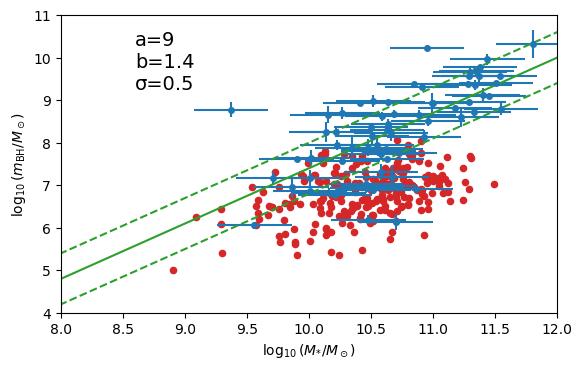

In [12]:
# Plot for the SMBHs and the spread of the SMBHs luminosity function, we show the best fit to the local IG data taken from https://arxiv.org/pdf/2403.19650

x_meas = np.array([float(m[0][0]) for m in dynamicallymeasured], dtype=np.float64)
y_meas = np.array([float(m[0][1]) for m in dynamicallymeasured], dtype=np.float64)
xerr = np.array([float(m[1][0]) for m in dynamicallymeasured], dtype=np.float64)
yerr = np.array([float(m[1][1]) for m in dynamicallymeasured], dtype=np.float64)
# Second dataset (joined AGN data)
combined_agn = broadLINEAGNdata 
x_agn = np.array([float(d[0][0]) for d in combined_agn], dtype=np.float64)
y_agn = np.array([float(d[0][1]) for d in combined_agn], dtype=np.float64)


fig, ax = plt.subplots()

# Plot error bars and points
ax.errorbar(x_meas, y_meas, xerr=xerr, yerr=yerr, fmt='o', ms=4, color=('tab:blue'))
ax.scatter(x_agn, y_agn, s=20, color='tab:red')

x_line = np.linspace(5, 15, 11)
y_line = 8.7 + 1.3 * (x_line - 11)
ax.plot(x_line, y_line, color='tab:green')
ax.plot(x_line, y_line + 0.6, linestyle='--', color='tab:green')
ax.plot(x_line, y_line - 0.6, linestyle='--', color='tab:green')

# Plot ranges encompassing both specifications
ax.set_xlim(8, 12)
ax.set_ylim(4, 11)

# Labels
ax.set_xlabel(r'$\log_{10}\left(M_{*}/M_\odot\right)$')
ax.set_ylabel(r'$\log_{10}\left(m_{\rm BH}/M_\odot\right)$')

# Text annotation at axes-scaled position
ax.text(0.15, 0.75, 'a=9\nb=1.4\nσ=0.5', fontsize=14, transform=ax.transAxes)

# Optional aspect ratio similar to Mathematica's
ax.set_box_aspect(0.6)


### Merger rate

In [ ]:
# Montecarlo integral over the spread of the SMBH mass stellar mass relation 

def Rastro_qmc(m1, m2, z, a, b, sigma, n):
    
    # Convert to arrays
    m1 = np.atleast_1d(m1)
    m2 = np.atleast_1d(m2)
    z = np.atleast_1d(z)
    m1, m2, z = np.broadcast_arrays(m1, m2, z)
    
    n_points = m1.size
    m1_flat = m1.ravel()
    m2_flat = m2.ravel()
    z_flat = z.ravel()
    
    # Generate Sobol samples
    sob = qmc.Sobol(d=2, scramble=False, seed=None)
    u = sob.random(n)
    
    # Compute bounds for all points (vectorize if possible)
    lo = np.array([
        min(logmvMin(m1_flat[i], z_flat[i], a, b, 0, sigma),
            logmvMin(m2_flat[i], z_flat[i], a, b, 0, sigma))
        for i in range(n_points)
    ])

    hi = 18
    
    # Reshape for broadcasting: (n_points, 1) × (1, n_samples)
    lo = lo[:, np.newaxis]
    
    # Generate all M1, M2 samples for all points
    
    logM1 = lo + (hi - lo) * u[np.newaxis, :, 0]
    logM2 = lo + (hi - lo) * u[np.newaxis, :, 1]
    
    M1 = 10.0 ** logM1
    M2 = 10.0 ** logM2
    
    # Broadcast m1, m2, z to match shape
    m1_bc = m1_flat[:, np.newaxis]
    m2_bc = m2_flat[:, np.newaxis]
    z_bc = z_flat[:, np.newaxis]
    
    # Compute all integrands (if Rloglog and pMBH support this broadcasting)
    vals = (
        Rloglog(M1, M2, z_bc)
        * pMBH(m1_bc, M1, 0.0, a, b, 0.0, sigma)
        * pMBH(m2_bc, M2, 0.0, a, b, 0.0, sigma)
    )
    
    # Compute integrals for all points
    area = (hi - lo.ravel()) ** 2
    results = area * np.mean(vals, axis=1)
    
    return results[0] if n_points == 1 else results.reshape(m1.shape)

# To use directly in the P^1 function 

def Rlocal(m1, m2, z):
    return  Rastro_qmc(m1, m2, z, 9, 1.5, 0.5, 2**10)

In [ ]:
# to save a file for later interpolate the merger rate 

def build_and_save_Rastro_grid(a, b, sigma, n=2**12, m_range=(1e7, 1e11), m_points=40, logz_range=(-5, np.log10(3.0)), z_points=10, filename='Rastro_grid.npz'):
    
    # Create grids
    log_m1_grid = np.linspace(np.log10(m_range[0]), np.log10(m_range[1]), m_points)
    log_m2_grid = np.linspace(np.log10(m_range[0]), np.log10(m_range[1]), m_points)
    log_z_grid = np.linspace(logz_range[0], logz_range[1], z_points)
    
    m1_grid = 10**log_m1_grid
    m2_grid = 10**log_m2_grid
    z_grid = 10**log_z_grid
    
    values = np.zeros((m_points, m_points, z_points))
    
    print(f"Computing grid:{m_points*m_points*z_points} points")
    
    total = m_points * m_points * z_points
    count = 0
    
    for i, m1 in enumerate(m1_grid):
        for j, m2 in enumerate(m2_grid):
            for k, z in enumerate(z_grid):
                try:
                    values[i, j, k] = np.log10(Rastro_qmc(m1, m2, z, a, b, sigma, n))
                except:
                    values[i, j, k] = 0.0
                
                count += 1
                if count % 200 == 0:
                    print(f"  {count}/{total} ({100*count/total:.1f}%)")
    
    # Save everything as numpy arrays
    np.savez(filename,
             log_m1_grid=log_m1_grid,
             log_m2_grid=log_m2_grid,
             log_z_grid=log_z_grid,
             values=values,
             a=a,
             b=b,
             sigma=sigma,
             n=n)
    
    print(f"✓ Saved grid data to {filename}")
    print(f"  File size: {os.path.getsize(filename) / 1024:.1f} KB")

In [30]:
# to load the interpolating file with the merger rate 

def load_Rastro_interpolator(filename='Rastro_grid.npz', method='linear'):
    
    data = np.load(filename)
    
    log_m1_grid = data['log_m1_grid']
    log_m2_grid = data['log_m2_grid']
    log_z_grid = data['log_z_grid']
    values = data['values']
    
    # Print info
    print(f"✓ Loaded grid from {filename}")
    print(f"  Parameters: a={data['a']}, b={data['b']}, sigma={data['sigma']}")
    print(f"  Grid shape: {values.shape}")
    print(f"  m1 range: [{10**log_m1_grid[0]:.1e}, {10**log_m1_grid[-1]:.1e}]")
    print(f"  z range: [{10**log_z_grid[0]:.1e}, {10**log_z_grid[-1]:.1e}]")
    
    # Build interpolator
    interpolator = RegularGridInterpolator(
        (log_m1_grid, log_m2_grid, log_z_grid),
        values,
        method=method,
        bounds_error=False,
        fill_value=None)
    
    # Return a callable function
    def Rastro_interp(m1, m2, z):
        # Convert all inputs to arrays (handles both scalar and array inputs)
        m1 = np.atleast_1d(m1)
        m2 = np.atleast_1d(m2)
        z = np.atleast_1d(z)
    
        # Transform to log space with safety bounds
        log_m1 = np.log10(np.maximum(m1, 1e3))
        log_m2 = np.log10(np.maximum(m2, 1e3))
        log_z = np.log10(np.maximum(z, 1e-5))
    
        # Create points array for interpolation
        points = np.column_stack([log_m1, log_m2, log_z])
    
        # Interpolate and transform back from log space
        result = 10**interpolator(points)
    
        # Return scalar if input was scalar, otherwise return array
        return result[0] if result.shape[0] == 1 else result

    return Rastro_interp

In [25]:
# This computes the Rastro grid and saves it, you can compute this only once, this is the model for the local IG galaxies, you only need to run this once
# build_and_save_Rastro_grid(a=9.0, b=1.4, sigma=0.5)

In [26]:
# Now you load the data and construct the interpolator 
Rastro_interp = load_Rastro_interpolator('Rastro_grid.npz')

✓ Loaded grid from Rastro_grid.npz
  Parameters: a=9.0, b=1.4, sigma=0.5
  Grid shape: (40, 40, 10)
  m1 range: [1.0e+07, 1.0e+11]
  z range: [1.0e-05, 3.0e+00]


In [ ]:
yvalues=[Rastro_qmc(1e8, 10**logm, 0., 9., 1.4, 0.5,  2**12) for logm in np.linspace(7, 10, 30)]
yvalues2=[Rastro_qmc(1e9, 10**logm, 0., 9., 1.4, 0.5, 2**12) for logm in np.linspace(7, 10, 30)]
yvalues3=[Rastro_qmc(1e10, 10**logm, 0., 9., 1.4, 0.5, 2**12) for logm in np.linspace(7, 10, 30)]
yvaluesa=[Rastro_interp(1e8, 10**logm, 0.) for logm in np.linspace(7, 10, 30)]
yvalues2a=[Rastro_interp(1e9, 10**logm, 0.) for logm in np.linspace(7, 10, 30)]
yvalues3a=[Rastro_interp(1e10, 10**logm, 0.) for logm in np.linspace(7, 10, 30)]
xvalues=[10**z for z in np.linspace(7, 10, 30)]

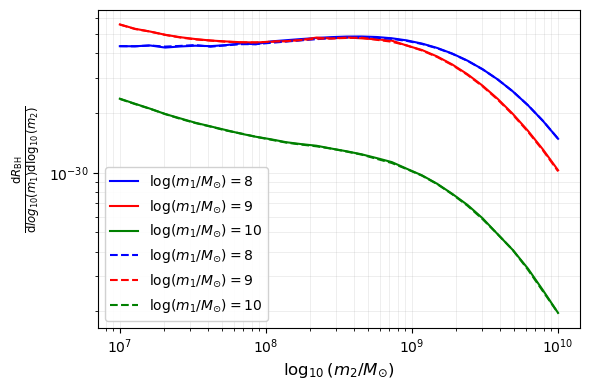

In [34]:
plt.figure(figsize=(6, 4))
# Plot with labels and custom styles
plt.plot(xvalues, yvalues, label=r'$\log(m_1/M_{\odot})=8$', color='blue')
plt.plot(xvalues, yvalues2, label=r'$\log(m_1/M_{\odot})=9$',color='red')
plt.plot(xvalues, yvalues3, label=r'$\log(m_1/M_{\odot})=10$', color='green')
plt.plot(xvalues, yvaluesa, label=r'$\log(m_1/M_{\odot})=8$', color='blue',linestyle='--')
plt.plot(xvalues, yvalues2a, label=r'$\log(m_1/M_{\odot})=9$',color='red',linestyle='--')
plt.plot(xvalues, yvalues3a, label=r'$\log(m_1/M_{\odot})=10$', color='green',linestyle='--')
# Log scales
plt.xscale('log')
plt.yscale('log')
# Labels with optional LaTeX formatting
plt.xlabel(r'$\log_{10}(m_2/M_{\odot})$', fontsize=12)
plt.ylabel(r'$\frac{{\rm d} R_{\rm BH}}{{\rm d}log_{10}(m_1){\rm d}\log_{10}(m_2)}$', fontsize=12)  # Use r'' for LaTeX
# Grid for both major and minor ticks
plt.grid(True, alpha=0.3, which='both', linestyle='-', linewidth=0.5)
# Legend with styling
plt.legend(loc='lower left', framealpha=0.9, fontsize=10, frameon=True)
plt.tight_layout()
plt.show()

### Luminosity function

In [157]:
def dNdlog10Alogf(R, logA, fgw, pbh, fref, alpha, beta, n_outer):
    
    # Create interpolator for Mc(z) - use log-scale for grid
    logz_grid = np.linspace(-4, np.log10(2.99), 100)
    z_grid = 10**logz_grid
    Mc_grid = np.array([McA(10**logA, zi, fgw) for zi in z_grid])
    Mc_interp = interp1d(z_grid, Mc_grid, kind='linear', fill_value='extrapolate')
    
    # Generate Sobol samples
    sob = qmc.Sobol(d=2, scramble=True, seed=None)
    u = sob.random(n_outer)
    
    # Map to integration domain
    eta_lo, eta_hi = 1e-3, 0.249
    logz_lo, logz_hi = -5, np.log10(2.99)  # Integration in log10(z)
    
    # Sample uniformly in eta and log10(z)
    eta = eta_lo + (eta_hi - eta_lo) * u[:, 0]
    logz = logz_lo + (logz_hi - logz_lo) * u[:, 1]
    
    # Convert back to z
    z = 10**logz
    
    # Evaluate Mc and masses
    Mc = Mc_interp(z)
    m1, m2 = m1m2(Mc, eta)
    
    # Compute discriminant for all samples
    disc = 1.0 - 4.0 * eta
    valid_disc = disc > 1e-10
    
    # Kernel for eta integration (2 / (sqrt(disc) * eta))
    kernel = np.zeros_like(eta)
    kernel[valid_disc] = 2.0 / (np.sqrt(disc[valid_disc]) * eta[valid_disc])
    
    # Compute integrand with Jacobian for log10(z): z * ln(10)
    # d(log10 z) = dz / (z * ln(10)), so dz = z * ln(10) * d(log10 z)
    jacobian = z * np.log(10)
    
    vals = (
        kernel * dlnMcdlnA * jacobian * DVc(z) / (1 + z) 
        * pbh * R(m1, m2, z) 
        * dtdlnf(2*fgw/(1+z), Mc, z, alpha, beta, fref)
    )
    
    # Apply validity masks
    vals[~valid_disc] = 0.0
    vals[~np.isfinite(vals)] = 0.0
    
    # Compute integral - area is now in (eta, log10(z)) space
    area = (eta_hi - eta_lo) * (logz_hi - logz_lo)
    result = area * np.mean(vals)
    
    return result

In [158]:
yval1= [dNdlog10Alogf(Rastro_interp, logOmega, 1e-9, 1, 10**-13, 5/8, 8/3,2**10) for logOmega in np.linspace(-20, -10, 40)]
xval1= [10**logOmega for logOmega in np.linspace(-20, -10, 40)]

In [159]:
yval2= [10**(-3*logOmega - 42) for logOmega in np.linspace(-20, -10, 40)]
xval2= [10**logOmega for logOmega in np.linspace(-20, -10, 40)]

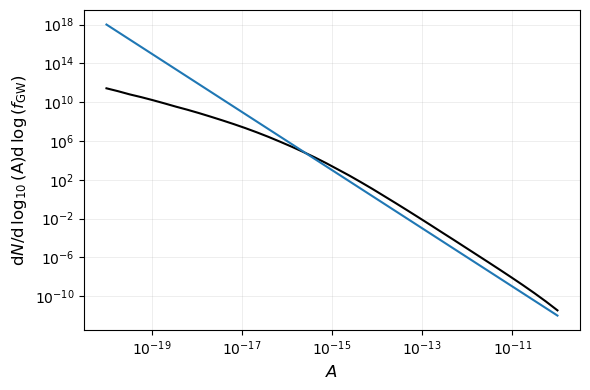

In [ ]:
plt.figure(figsize=(6, 4))
# Plot with labels and custom styles
plt.plot(xval1, yval1, color='black')
plt.plot(xval2, yval2, color='black')

# Log scales
plt.xscale('log')
plt.yscale('log')
# Labels with optional LaTeX formatting
plt.xlabel(r'$A$', fontsize=12)
plt.ylabel(r'${\rm d}N/{\rm d\,\log_{10}\left(A\right)}{\rm d}\,\log\left(f_{\rm GW}\right)}$', fontsize=12) 
# Grid for both major and minor ticks
plt.grid(True, alpha=0.3, which='both', linestyle='-', linewidth=0.5)
# Legend with styling
plt.tight_layout()
plt.show()

It works very well, now the idea is to compute the PDF generator from the luminosity function 

In [ ]:
# This is from Juhan's code I have copied below more functions...

def sample_from_pdf(pdf_func, n_samples, domain_min, domain_max, grid_points=500):
    """
    Generates random samples from a given PDF using inverse transform sampling.

    Args:
        pdf_func (callable): The probability density function to sample from.
        n_samples (int): The number of samples to generate.
        domain_min (float): The minimum of the domain for the PDF.
        domain_max (float): The maximum of the domain for the PDF.
        grid_points (int, optional): The number of points for numerical integration.

    Returns:
        np.ndarray: An array of samples drawn from the PDF.
    """
    # Get numerical PDF (not function)
    grid = np.linspace(domain_min, domain_max, grid_points)
    pdf_values = pdf_func(grid)

    # Replace any potential NaNs from the PDF calculation with zero
    pdf_values = np.nan_to_num(pdf_values, nan=0.0)

    # Get CDF
    cdf_values = cumulative_trapezoid(pdf_values, grid, initial=0)

    # Normalize the CDF and create interpolator for inverse CDF
    if cdf_values[-1] > 0:
        cdf_values /= cdf_values[-1]

    inv_cdf = interp1d(
        cdf_values,
        grid,
        kind='linear',
        bounds_error=False,
        fill_value=(domain_min, domain_max)
    )
    # Sample inverse CDF
    uniform_samples = np.random.rand(int(n_samples))
    final_samples = inv_cdf(uniform_samples)

    return final_samples

In [ ]:
# This function is updated with Juhan's code

def findOmegatotastro(xs, ys, f0, Delta_f0, n_realizations=10000, n_strong=50):
    
    # Work in log space

    log_xdat = np.log10(xs)
    log_ydat = np.log10(ys)
    
    # Create interpolator for the single-source PDF
    
    LPlogOmega1 = interp1d(log_xdat, log_ydat, kind='linear', 
                          fill_value='extrapolate', bounds_error=False)
    
    start = log_xdat[0]
    end = log_xdat[-2]
    limit = log_xdat[-1]
    
    delta_ln_f = np.log((f0 + Delta_f0 / 2) / (f0 - Delta_f0 / 2))
    
    # Calculate normalization integral from different cutoffs
    def integral_norm(log10_start):
        val, _ = quad(lambda x: 10.0 ** LPlogOmega1(x), log10_start, limit)
        return val
    
    # Find total number of sources in this frequency bin

    total_integral = integral_norm(start)
    N_tot = delta_ln_f * total_integral
    
    print(f"  N_tot (total sources in bin) = {N_tot:.2f}")
    
    # Find threshold separating weak and strong sources
    LOmega_min = start
    if N_tot > n_strong:
        def equation(log_omega_min):
            return delta_ln_f * integral_norm(log_omega_min) - n_strong
        sol = optimize.root_scalar(equation, bracket=[start, end -0.1], method='brentq')
        LOmega_min = sol.root
    
    # Calculate weak source contribution (mean and variance)

    def integrand_Omega(log10_om):
        return 10**log10_om * 10**LPlogOmega1(log10_om)
    
    def integrand_OmegaSqr(log10_om):
        return (10**log10_om)**2 * 10**LPlogOmega1(log10_om)
    
    dOmega_low, _ = quad(integrand_Omega, start, LOmega_min)
    dOmega_low_sqr, _ = quad(integrand_OmegaSqr, start, LOmega_min)
    
    # Calculate sigma for weak sources  

    sigma_arg = dOmega_low_sqr - dOmega_low**2 / (total_integral - n_strong * delta_ln_f)
    sigma_weak = np.sqrt(sigma_arg) if sigma_arg > 0 else 0
    mean_weak = dOmega_low
    
    integral_strong = integral_norm(LOmega_min)
    
    print(f"  Mean weak source contribution = {mean_weak:.4e}")
    print(f"  Sigma weak = {sigma_weak:.4e}")
    
    # Generate strong source samples using inverse transform sampling

    total_strong_samples = n_realizations * n_strong
    
    # Use Juhan's sample_from_pdf function for better sampling

    p1_func = lambda log10_om: 10**LPlogOmega1(log10_om)
    
    sampled_log10_omega_flat = sample_from_pdf(
        pdf_func=p1_func,
        n_samples=total_strong_samples,
        domain_min=LOmega_min,
        domain_max=end
    )
    
    sampled_log10_omega = sampled_log10_omega_flat.reshape((n_realizations, n_strong))
    
    # Combine weak and strong components

    dOmega_strong_total = np.sum(10**sampled_log10_omega, axis=1)
    strong_spectrum = dOmega_strong_total / delta_ln_f
    
    print("  Convolving weak and strong distributions...")

    weak_samples = np.random.normal(
        loc=mean_weak,
        scale=sigma_weak,
        size=n_realizations
    )

    tailless_spectrum = weak_samples + strong_spectrum
    
    print(f"  Mean total signal (from MC) = {np.mean(tailless_spectrum):.4e}")
    
    # Calculate total integrated Omega for analytic tail

    dOmega_tot, _ = quad(integrand_Omega, start, end)
    
    # Create glued distribution with analytic tail (Juhan's method)
    print("  Creating glued distribution with analytic tail...")
    
    positive_spec = tailless_spectrum[tailless_spectrum > 0]
    if len(positive_spec) < 2:
        raise ValueError("Not enough positive simulation data to create a KDE.")
    
    kde_body = gaussian_kde(np.log10(positive_spec))
    
    # Find switch point where we transition to analytic tail
    
    log10_spectrum = np.log10(positive_spec)
    dL_omega_bin = 0.02
    min_bin_count = 50
    
    bins = np.arange(log10_spectrum.min(), log10_spectrum.max(), dL_omega_bin)
    hist, _ = np.histogram(log10_spectrum, bins=bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    valid_indices = np.where(hist >= min_bin_count)
    if len(valid_indices[0]) < 2:
        log_omega_switch = np.percentile(log10_spectrum, 95)
    else:
        log_omega_switch = bin_centers[valid_indices][-1]
    
    print(f"  Switch point to analytic tail: {log_omega_switch:.4f}")
    
    # Create glued PDF function
    
    def glued_pdf(log_omega):
        """PDF with KDE for body and analytic formula for tail"""
        with np.errstate(invalid='ignore'):
            analytic_tail = (1 / (1 - dOmega_tot / 10**log_omega)) * n_strong * (
                p1_func(np.log10(10**log_omega - dOmega_tot) + np.log10(delta_ln_f)) / integral_strong
            )
        return np.where(log_omega < log_omega_switch, kde_body(log_omega), analytic_tail)
    
    # Return results including the glued PDF
    return (f0, positive_spec, glued_pdf, dOmega_tot, delta_ln_f, integral_strong, n_strong)

In [72]:
dat1=findOmegatotastro(xval1, yval1, 10e-9, 2*1e-9)

  N_tot (total sources in bin) = 2222362.07
  LOmega_min (strong source threshold) = -11.8268
  Mean weak source contribution = 2.1217e-09
  Sigma weak = 2.4770e-11
  Convolving weak and strong distributions...
  Mean total signal (from MC) = 3.8867e-09
  Creating glued distribution with analytic tail...
  Switch point to analytic tail: -8.2210


/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_7311/1648565068.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, _ = quad(lambda x: 10.0 ** LPlogOmega1(x), log10_start, limit)


In [80]:
yval = [dat1[2](logO) for logO in np.linspace(-9,-7,100)]
xval = np.linspace(-9,-7,100)

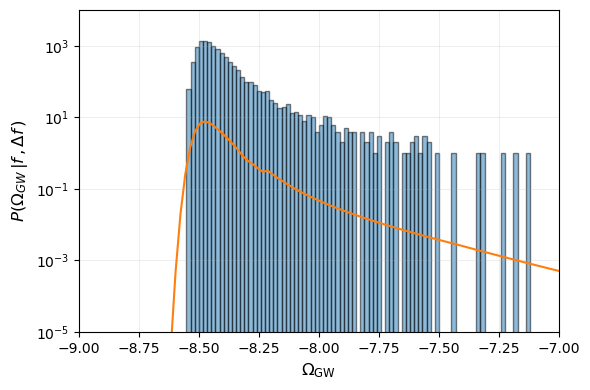

In [87]:
# Plot histogram
plt.figure(figsize=(6,4))
plt.hist(np.log10(dat1[1]), bins=100, edgecolor='black', alpha=0.5)
plt.plot(xval,yval)
# Labels with optional LaTeX formatting
plt.xscale('linear')
plt.yscale('log')
# Set x-axis range
plt.xlim(-9,-7)  # min, max
# Set y-axis range
plt.ylim(1e-5, 1e4)  # min, max
plt.xlabel(r'$\Omega_{\rm GW}$', fontsize=12)
plt.ylabel(r'$P\left(\Omega_{GW}\,|f\, ,\Delta f\, \right)$', fontsize=12)  # Use r'' for LaTeX
# Grid for both major and minor ticks
plt.grid(True, alpha=0.3, which='both', linestyle='-', linewidth=0.5)
# Legend with styling
plt.tight_layout()
plt.show()

## Log-likelihoods 

In [28]:
# First, we get the log-likelihood for the scaling relation 

def meanr(Ms, a, b):
    return a + b * np.log10(Ms / (10**11))

def pSMBH(Ms, a, b, sigma):
    return stats.norm(loc=meanr(Ms, a, b), scale=sigma)

def logL(a, b, sigma, data):
    vals = []
    for d in data:
        mx, my = d[0][0], d[0][1]
        sx, sy = d[1][0], d[1][1]
        mvn = stats.multivariate_normal(mean=[mx, my], cov=[[sx**2, 0], [0, sy**2]])

        def integrand(x, y):
            return mvn.pdf([x, y]) * stats.norm(loc=meanr(10**x, a, b), scale=sigma).pdf(y)
        res, _ = dblquad(
            lambda y, x: integrand(x, y),  
            mx - 3 * sx, mx + 3 * sx,      
            lambda x: my - 3 * sy,          
            lambda x: my + 3 * sy,          
            epsrel=1e-3, epsabs=1e-3
        )
        vals.append(res)
    return np.sum(-2 * np.log(vals))

In [29]:
logL(9, 1.4, 0.6, dynamicallymeasured)

170.1908692053763

In [30]:
class GWSpectrum:
    """
    Samples the single-source distribution to build up the total GW spectrum PDF.
    """
    def __init__(self, f0, delta_f, params, n_realizations, n_strong):
        """Initializes the simulation with all necessary parameters."""
        self.f0 = f0
        self.delta_f = delta_f
        self.params = params
        self.n_realizations = n_realizations
        self.n_strong = n_strong

        self.tailless_spectrum = None
        self.strong_spectrum = None
        self.mean_weak = None
        self.sigma_weak = None
        self.p1_func = None
        self.delta_ln_f = None
        self.dOmega_tot = None
        self.integral_strong = None
        self.glued_pdf = None
        self.switch_point = None
        self.final_pdf_bins = None
        self.final_pdf_values = None

    def build_pdf_model(self):
        """Executes the simulation and constructs the final PDF model with analytic tail attached."""
        print(f"--- Building PDF model for f = {self.f0*1e9:.3f} nHz ---")
        self._run_initial_simulation()
        self._create_glued_distribution()
        print("  Model built.")

    def generate_final_samples(self, n_samples, n_bins=100):
        """
        Generates samples and stores the final distribution as a normalized histogram.
        """

        domain_min = np.log10(self.mean_weak) - 2 if self.mean_weak > 0 else -12
        domain_max = self.switch_point + 2

        # Generate the large number of samples internally
        log_omega_samples = sample_from_pdf(self.glued_pdf, n_samples, domain_min, domain_max)
        omega_samples = 10**log_omega_samples

        # Create a histogram from the samples
        counts, bin_edges = np.histogram(np.log10(omega_samples), bins=n_bins)

        # Normalize the histogram to create a PDF
        bin_widths = np.diff(bin_edges)
        total_area = np.sum(counts * bin_widths)

        pdf_values = counts / total_area
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Store the binned PDF
        self.final_pdf_bins = bin_centers
        self.final_pdf_values = pdf_values

        return omega_samples

    def _run_initial_simulation(self):
        """Performs the initial Monte Carlo simulation to get the tailless spectrum."""
        log10_omega_min_domain, log10_omega_max_domain = -15.0, 1.0
        self.delta_ln_f = np.log((self.f0 + self.delta_f / 2) / (self.f0 - self.delta_f / 2))

        def integral_norm(log10_start, params):
            def integrand(log10_omega, p_dict):
                return p1_log10_unnormalized(log10_omega, self.f0, self.delta_f, p_dict)
            val, _ = quad(integrand, log10_start, log10_omega_max_domain, args=(params,))
            return val

        # Find the threshold separating weak and strong sources
        total_integral = integral_norm(log10_omega_min_domain, self.params)
        N_tot = self.delta_ln_f * total_integral
        print(f"  N_tot (total sources in bin) = {N_tot:.2f}")

        LOmega_min_log10 = log10_omega_min_domain
        if N_tot > self.n_strong:
            def equation(log_omega_min):
                return self.delta_ln_f * integral_norm(log_omega_min, self.params) - self.n_strong
            sol = root_scalar(equation, bracket=[log10_omega_min_domain, log10_omega_max_domain - 0.1], method='brentq')
            LOmega_min_log10 = sol.root

        print(f"  LOmega_min (strong source threshold) = {LOmega_min_log10:.4f}")

        # Calculate the weak source contribution (mean and standard deviation)
        def integrand_Omega(log10_om, p): return 10**log10_om * p1_log10_unnormalized(log10_om, self.f0, self.delta_f, p)
        def integrand_OmegaSqr(log10_om, p): return (10**log10_om)**2 * p1_log10_unnormalized(log10_om, self.f0, self.delta_f, p)

        dOmega_low, _ = quad(integrand_Omega, log10_omega_min_domain, LOmega_min_log10, args=(self.params,))
        dOmega_low_sqr, _ = quad(integrand_OmegaSqr, log10_omega_min_domain, LOmega_min_log10, args=(self.params,))

        sigma_arg = dOmega_low_sqr - dOmega_low**2 / (total_integral - self.n_strong * self.delta_ln_f)
        self.sigma_weak = np.sqrt(sigma_arg) if sigma_arg > 0 else 0
        self.mean_weak = dOmega_low
        self.integral_strong = integral_norm(LOmega_min_log10, self.params)
        self.p1_func = lambda log10_om: p1_log10_unnormalized(log10_om, self.f0, self.delta_f, self.params)

        # Generate the strong source contribution via inverse transform sampling
        total_strong_samples = self.n_realizations * self.n_strong
        sampled_log10_omega_flat = sample_from_pdf(
            pdf_func=self.p1_func,
            n_samples=total_strong_samples,
            domain_min=LOmega_min_log10,
            domain_max=log10_omega_max_domain
        )
        sampled_log10_omega = sampled_log10_omega_flat.reshape((self.n_realizations, self.n_strong))

        # Combine weak and strong components to get the tailless spectrum
        dOmega_strong_total = np.sum(10**sampled_log10_omega, axis=1)
        self.strong_spectrum = dOmega_strong_total / self.delta_ln_f

        print("  Convolving weak and strong distributions by direct sampling...")
        weak_samples = np.random.normal(
            loc=self.mean_weak,
            scale=self.sigma_weak,
            size=self.n_realizations
        )
        self.tailless_spectrum = weak_samples + self.strong_spectrum

        # self.tailless_spectrum = self.mean_weak + self.strong_spectrum
        print(f"  Mean total signal (from MC) = {np.mean(self.tailless_spectrum):.4e}")

        # Calculate the total integrated Omega for use in the analytic tail
        self.dOmega_tot, _ = quad(integrand_Omega, log10_omega_min_domain, log10_omega_max_domain, args=(self.params,))

    def _create_glued_distribution(self):
        """Builds the final PDF by gluing the analytic tail to a PDF of the raw data."""
        positive_spec = self.tailless_spectrum[self.tailless_spectrum > 0]
        if len(positive_spec) < 2:
            raise ValueError("Not enough positive simulation data to create a KDE.")

        kde_body = gaussian_kde(np.log10(positive_spec))

        self.glued_pdf, self.switch_point = create_glued_distribution(
            positive_spec, kde_body, self.p1_func, self.n_strong, self.delta_ln_f,
            self.dOmega_tot, self.integral_strong
        )

# =============================================================================
# Tail helpers
# =============================================================================

def create_glued_distribution(total_spectrum, kde_body, strong_pdf_func, n_strong,
                              delta_ln_f, dOmega_tot, integral_strong,
                              dL_omega_bin=0.02, min_bin_count=50):
    """Creates a distribution by gluing an analytic tail to the PDF of the simulation."""
    log10_spectrum = np.log10(total_spectrum)

    # Use a histogram of the raw data to find a reasonable point to switch to the analytic tail
    bins = np.arange(log10_spectrum.min(), log10_spectrum.max(), dL_omega_bin)
    hist, _ = np.histogram(log10_spectrum, bins=bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    valid_indices = np.where(hist >= min_bin_count)
    if len(valid_indices[0]) < 2:
        print("Warning: Not enough data to find a reliable switch point.")
        log_omega_switch = np.percentile(log10_spectrum, 95)
    else:
        log_omega_switch = bin_centers[valid_indices][-1]

    def glued_pdf(log_omega):
        with np.errstate(invalid='ignore'):
            analytic_tail = (1 / (1 - dOmega_tot / 10**log_omega)) * n_strong * (strong_pdf_func(np.log10(10**log_omega - dOmega_tot) + np.log10(delta_ln_f)) / integral_strong)
        return np.where(log_omega < log_omega_switch, kde_body(log_omega), analytic_tail)

    return glued_pdf, log_omega_switch

def create_analytic_tail_function(p1_func, n_strong, delta_ln_f, dOmega_tot, integral_strong):
    """Callable function representing the complete analytic tail formula."""
    def analytic_tail_formula(log_omega):
        with np.errstate(invalid='ignore'):
            return (1 / (1 - dOmega_tot / 10**log_omega)) * n_strong * (p1_func(np.log10(10**log_omega - dOmega_tot) + np.log10(delta_ln_f)) / integral_strong)
    return analytic_tail_formula

In [38]:
# utils.py

def load_parameters_from_file(file_path):
    """
    Loads simulation parameters for the BPL model from a text file.
    The file should be space-separated and can contain commented lines starting with '#'.

    Args:
        file_path (str): The path to the parameter file.

    Returns:
        pd.DataFrame: A DataFrame containing the parameters, or None if an error occurs.
    """
    try:
        df = pd.read_csv(file_path, sep=r'\s+', comment='#', header=None)
        df.columns = ['Frequency', 'A', 'alpha', 'beta', 'gamma', 'omega_break']
        return df
    except Exception as e:
        print(f"--- ERROR: Could not parse parameter file '{file_path}'. Error: {e} ---")
        return None

def sample_from_pdf(pdf_func, n_samples, domain_min, domain_max, grid_points=500):
    """
    Generates random samples from a given PDF using inverse transform sampling.

    Args:
        pdf_func (callable): The probability density function to sample from.
        n_samples (int): The number of samples to generate.
        domain_min (float): The minimum of the domain for the PDF.
        domain_max (float): The maximum of the domain for the PDF.
        grid_points (int, optional): The number of points for numerical integration.

    Returns:
        np.ndarray: An array of samples drawn from the PDF.
    """
    # Get numerical PDF (not function)
    grid = np.linspace(domain_min, domain_max, grid_points)
    pdf_values = pdf_func(grid)

    # Replace any potential NaNs from the PDF calculation with zero
    pdf_values = np.nan_to_num(pdf_values, nan=0.0)

    # Get CDF
    cdf_values = cumulative_trapezoid(pdf_values, grid, initial=0)

    # Normalize the CDF and create interpolator for inverse CDF
    if cdf_values[-1] > 0:
        cdf_values /= cdf_values[-1]

    inv_cdf = interp1d(
        cdf_values,
        grid,
        kind='linear',
        bounds_error=False,
        fill_value=(domain_min, domain_max)
    )
    # Sample inverse CDF
    uniform_samples = np.random.rand(int(n_samples))
    final_samples = inv_cdf(uniform_samples)

    return final_samples

In [31]:
def main():
    """Main execution function to run the simulation and generate plots."""

    # Parse arguments
    parser = argparse.ArgumentParser(
        description="Run and visualize a Gravitational Wave (GW) signal simulation.",
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )

    io_group = parser.add_argument_group("Input/Output Files")
    io_group.add_argument("param_file", type=str, help="Path to the BPL parameter file.")
    io_group.add_argument("--ng_data", type=str, default="NGdata.csv", help="Path to the NG15 data CSV for comparison.")
    io_group.add_argument("--output_file", type=str, default="results.txt", help="Path to save the final binned PDFs to a text file.")

    sim_group = parser.add_argument_group("Simulation Parameters")
    sim_group.add_argument("--n_realizations", type=int, default=int(1e5), help="Number of Monte Carlo realizations for the simulation.")
    sim_group.add_argument("--n_samples_output", type=int, default=int(1e6), help="Number of samples to generate from the final glued distribution for the output histogram.")
    sim_group.add_argument("--n_strong", type=int, default=50, help="Number of strong sources to simulate per realization (Nbin).")

    plot_group = parser.add_argument_group("Plotting Options")
    plot_group.add_argument("--no_plot", action="store_true", help="If specified, disables generating the final summary plot.")

    args = parser.parse_args()

    # Start timing
    total_start_time = time.perf_counter() # Start total timer

    # Build PDFs for each frequency from the parameter file
    params_df = load_parameters_from_file(args.param_file)
    if params_df is None:
        return

    frequencies = params_df['Frequency'].values
    delta_fs = np.diff(frequencies)
    delta_fs = np.append(delta_fs, delta_fs[-1])

    all_simulations = []

    print("\n--- Doing MC simulation to find PDFs ---")
    stage1_start_time = time.perf_counter()

    for i, row in params_df.iterrows():
        f0 = row['Frequency']
        delta_f = delta_fs[i]
        params_for_bin = {k: v for k, v in row.items() if k != 'Frequency'}

        sim = GWSpectrum(f0, delta_f, params_for_bin, args.n_realizations, args.n_strong)
        try:
            sim.build_pdf_model()
            all_simulations.append(sim)
        except Exception as e:
            print(f"    !!! MC FAILED. Error: {e} !!!")

    stage1_end_time = time.perf_counter()

    # Save final PDFs as histograms
    print("\n--- Generating Samples and Binning final PDF ---")
    stage2_start_time = time.perf_counter()
    results_for_saving = []
    total_sims = len(all_simulations)

    # Sampling with progress indication
    for i, sim in enumerate(all_simulations):
        print(f"  Sampling bin {i + 1} of {total_sims}...", end='\r')
        sys.stdout.flush()
        try:
            tailless_samples = sim.generate_final_samples(args.n_samples_output)
            results_for_saving.append({'f0': sim.f0, 'spectrum': tailless_samples})
        except Exception as e:
            print(f"\n    !!! SAMPLING FAILED for f={sim.f0*1e9:.3f} nHz. Error: {e} !!!")

    print(f"  Sampling bin {total_sims} of {total_sims}... Done.")

    final_binned_results = [
        {'f0': sim.f0, 'bins': sim.final_pdf_bins, 'pdf_values': sim.final_pdf_values}
        for sim in all_simulations if sim.final_pdf_bins is not None
    ]

    if args.output_file:
        if final_binned_results:
            all_data_to_save = []
            for res in final_binned_results:
                for i in range(len(res['bins'])):
                    all_data_to_save.append({
                        'Frequency_Hz': res['f0'],
                        'Log10_Omega_bin_center': res['bins'][i],
                        'PDF_value': res['pdf_values'][i]
                    })

            df_to_save = pd.DataFrame(all_data_to_save)
            df_to_save.to_csv(args.output_file, sep='\t', index=False, float_format='%.6e')
            print(f"\nFinal binned PDFs saved to {args.output_file}")
        else:
            print("\nNo results to save as all simulations failed before sampling.")

    stage2_end_time = time.perf_counter()


    # Generate summary plot
    if not args.no_plot:
        print("\nGenerating final summary plot...")
        N_SAMPLES_FOR_PLOT = 10000
        results_for_plotting = []
        for i, sim in enumerate(all_simulations):
            sys.stdout.flush()
            # Generate a small number of samples for the violin plot
            plot_samples = sim.generate_final_samples(N_SAMPLES_FOR_PLOT)
            results_for_plotting.append({'f0': sim.f0, 'spectrum': plot_samples})

        if not all_simulations:
            print("Skipping plot generation as no simulations were successful.")
            return

        fig, axes = plt.subplots(ncols=3, figsize=(30, 9))

        first_successful_sim = all_simulations[0]
        plot_bpl_panel(axes[0], first_successful_sim.f0, first_successful_sim.params)
        plot_distribution_breakdown_panel(axes[1], first_successful_sim.f0, first_successful_sim)

        # Call the original violin plotter with the raw samples we collected
        plot_violins_panel(axes[2], args.ng_data, results_for_plotting)

        plt.tight_layout()
        plt.savefig("simulation_summary.pdf", dpi=300)
        print("\nSummary plot saved to simulation_summary.pdf")


    # Timing summary
    total_end_time = time.perf_counter()
    print("\n--- Timing Summary ---")
    print(f"PDF Model Building ..... : {stage1_end_time - stage1_start_time:.2f} seconds")
    print(f"Final PDF Sampling ..... : {stage2_end_time - stage2_start_time:.2f} seconds")
    print(f"Total Execution Time ... : {total_end_time - total_start_time:.2f} seconds")

    if not args.no_plot:
        plt.show()


if __name__ == '__main__':
    main()

usage: ipykernel_launcher.py [-h] [--ng_data NG_DATA]
                             [--output_file OUTPUT_FILE]
                             [--n_realizations N_REALIZATIONS]
                             [--n_samples_output N_SAMPLES_OUTPUT]
                             [--n_strong N_STRONG] [--no_plot]
                             param_file
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

/Users/juanurrutia/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
